# Name Generator

Long Sort-term Memory Networks   
v3.3✨

In [1]:
# Importing required modules

# nD Array
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Utils
import time
import string
from collections import Counter


## Data Preprocessing

In [3]:
data_path = "/content/names.csv"
df = pd.read_csv(data_path)

df.drop(['Id', 'Year', 'Gender'], axis=1, inplace=True)

print(df.shape)
df.head()

(1825433, 2)


,Name,Count
0,Mary,7065
1,Anna,2604
2,Emma,2003
3,Elizabeth,1939
4,Minnie,1746


In [4]:
def preprocess_name(name):
    name = name.lower().strip() # converting to lower case and triming extra space
    name = "".join([c for c in name if c in string.ascii_lowercase]) # only allowing ASCII Lowercase characters and removing symbols and other charactors
    return name

In [5]:
df['Name'] = df['Name'].apply(preprocess_name)
df.head()

,Name,Count
0,mary,7065
1,anna,2604
2,emma,2003
3,elizabeth,1939
4,minnie,1746


In [6]:
names = df[['Name', 'Count']].groupby('Name').sum() # unique names from the 'Name' column and the corresponding sum of all the 'Count' values for each unique name
print("We have", len(names), "unique names.")

We have 93889 unique names.


In [7]:
max_length = pd.Series(names.index).apply(len).max() # Checking the maximum length in our dataset names
print("Maximum length of a name in the database is ", max_length)

Maximum length of a name in the database is  15


In [8]:
names = names.sort_values(by=['Count'], ascending=False)
names.head()

,Count
Name,
james,5129096
john,5106590
robert,4816785
michael,4330805
mary,4130441


In [9]:
names['Count'].describe()

count    9.388900e+04
mean     3.590787e+03
std      5.566563e+04
min      5.000000e+00
25%      1.100000e+01
50%      4.500000e+01
75%      2.370000e+02
max      5.129096e+06
Name: Count, dtype: float64

In [11]:
# Applying Alpha Transform to reduce impact of outliers

alpha = 0.8
names['count_normalized'] = names['Count'].apply(lambda x: np.power(x, alpha)).apply(int)
names.head()

,Count,count_normalized
Name,,
james,5129096,233363
john,5106590,232543
robert,4816785,221924
michael,4330805,203823
mary,4130441,196244


In [12]:
# calculating the proportion of each name's count

names['proportion'] = names['count_normalized'] / names['count_normalized'].sum()
names.head()

,Count,count_normalized,proportion
Name,,,
james,5129096,233363,0.007302
john,5106590,232543,0.007276
robert,4816785,221924,0.006944
michael,4330805,203823,0.006378
mary,4130441,196244,0.006140


In [13]:
sz = len(df['Name']) // 10
sz

182543

In [14]:
# Randomnly selecting the names from dataset

np.random.seed(0) # making sure that the random number is same-ish each time
names_list = np.random.choice(names.index, size=sz, p=names['proportion'], replace=True)
print(len(names_list))
print(names_list[:50])

182543
['lonnie' 'kiley' 'elena' 'peyton' 'kristen' 'tessa' 'lucas' 'karalee'
 'trenisha' 'carrie' 'yaritza' 'grant' 'kendall' 'orlean' 'elizabeth'
 'barbara' 'robert' 'ema' 'uriah' 'paden' 'gresham' 'brandan' 'rosa'
 'deonte' 'susan' 'liliana' 'ryan' 'wilfrido' 'cora' 'mason' 'jordan'
 'kami' 'manuel' 'kurt' 'robert' 'salvatore' 'giovanni' 'erma' 'ilyse'
 'cary' 'josephine' 'ava' 'vance' 'thomas' 'patrice' 'janine' 'virginia'
 'jessica' 'danielle' 'leonard']


In [15]:
pd.Series(names_list).value_counts()

james      1343
john       1294
robert     1279
michael    1149
william    1144
           ... 
sahiti        1
cassi         1
jeannee       1
allanah       1
laziah        1
Length: 23460, dtype: int64

In [16]:
# Utility sets for easy numeric conversion

char_to_id = {c:i for i, c in enumerate(string.ascii_lowercase + ".")}
id_to_char = {v:k for k, v in char_to_id.items()}
print(char_to_id)
print(id_to_char)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '.': 26}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '.'}


In [17]:
print(max_length)

15


In [18]:
num_chars = len(char_to_id) # 26 lower case alphabets and '.'
num_chars

27

In [20]:
class NamesDataset(Dataset):

    def __init__(self, names_list):
        self.names_list = names_list

    def __len__(self):
        return len(self.names_list)

    def __getitem__(self, idx):
        x_str = self.names_list[idx].ljust(max_length, ".")[:max_length] # adding "." as a padding for shorter names using "Left Justification" method
        y_str = x_str[1:] + "." # creating string with all characters shifted left by 1 and added "." as padding at the end

        # initializing data tensors with zeros
        x = torch.zeros((max_length, num_chars)) # 12 x 27
        y = torch.zeros(max_length) # 12 x 1

        # one-hot encoding
        for i, c in enumerate(x_str):
            x[i, char_to_id[c]] = 1 # setting 1 to corrosponding character

        for i, c in enumerate(y_str):
            y[i] = char_to_id[c]

        return x, y

In [21]:
trainset = NamesDataset(names_list)

In [22]:
# checking the trainset data

print(trainset[0])

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 

In [23]:
train_batch_size = 150

In [24]:
import os

cpu_count = os.cpu_count()
print(cpu_count)

2


In [25]:
train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=cpu_count)
print("Number of batches in the Data Loader is", len(train_loader))

Number of batches in the Data Loader is 1217


In [26]:
# Checking out 1 element of data loader

train_iter = iter(train_loader)
X, Y = next(train_iter)
print(X.size(), Y.size())

torch.Size([150, 15, 27]) torch.Size([150, 15])


## Model architecture

In [27]:
# Using GPU if available

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
device

device(type='cuda', index=0)

<!-- ![LSTM Illustration](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png) -->

![LSTM Example](https://livecodestream.dev/post/lstm-based-name-generator-first-dive-into-nlp/lstm-cell_hu1f74fdfa71fd76b4ba5a9ca5c516a9b0_65012_700x0_resize_q90_h2_lanczos_3.webp)

In [28]:
class Model(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Model, self).__init__() # initializing inherited class Module

        # sizes
        self.input_size = input_size
        self.hidden_size = hidden_size # number of neurons in LSTM, (higher val => higher overfitting)
        self.num_layers = num_layers # # number of recurrent (LSTM) layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # fully connected layers
        self.fc_1 = nn.Linear(hidden_size, output_size)
        self.fc_2 = nn.Linear(output_size, output_size)

    def forward(self, X, states):
        ht, ct = states # hidden state and the cell state of LSTM

        batch_size = X.size(0)

        out, (ht, ct) = self.lstm(X, (ht, ct))

        out = self.fc_1(out)
        out = F.relu(out) # ReLU is used to avoid vanishing gradient problem
        out = self.fc_2(out)

        return out, (ht, ct) # out: Size([batch_size, max_length, num_chars])

In [29]:
num_layers = 1
hidden_size = 50

model = Model(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers)
model = nn.DataParallel(model) # allows parallel training on multiple GPUs
model = model.to(device) # moving model to GPU if available
model

DataParallel(
  (module): Model(
    (lstm): LSTM(27, 50, batch_first=True)
    (fc_1): Linear(in_features=50, out_features=27, bias=True)
    (fc_2): Linear(in_features=27, out_features=27, bias=True)
  )
)

In [30]:
# initializing state tensors

ht = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device) # moving to GPU at the end
ct = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)


In [31]:
lr = 5 * 1e-3 # Learning Rate
gamma = 0.1 # factor by which to reduce the learning rate

step_size = len(train_loader) # step size for the learning rate scheduler, which means the learning rate will be reduced every epoch
print(step_size)

1217


In [32]:
criterion = nn.CrossEntropyLoss(reduction='mean') # Loss Function
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma) # reduces the learning rate by a factor of gamma every step_size iterations

In [33]:
def generate_name(model, start='j', k=5):
    """
    model: trained model
    start: string to start name with, bydefaule it's 'j'
    k: the model selects the top 'k' probable characters from the output and randomly selects one from them as the next character
    """

    # Not generating names longer than max_length (here 12)
    if len(start) >= max_length:
        return name

    with torch.no_grad(): # since no need to compute gradients for following operations

        # initializing hidden and cell states
        ht = torch.zeros((num_layers, 1, hidden_size)).to(device)
        ct = torch.zeros((num_layers, 1, hidden_size)).to(device)

        length = 0
        name = start

        # initialize the hidden and cell states for the LSTM network
        for char in start:
            X = torch.zeros((1, 1, num_chars)) # initializing one-hot encoded vector, [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1 # one-hot encoding

            out, (ht, ct) = model(X, (ht, ct)) # generating next character

            length += 1

        # Generating first new character
        vals, idxs = torch.topk(out[0], k) # top k most probable characters

        idx = np.random.choice(idxs.cpu().numpy()[0]) # selecting 1 of top k character randomnly
        char = id_to_char[idx]

        # Generating new characters, until we reach max length or generated character is "."
        while char != "." and length <= max_length-1:
            X = torch.zeros((1, 1, num_chars)) # args = (batch_size, timestep, num_chars)
            X[0, 0, char_to_id[char]] = 1

            out, (ht, ct) = model(X, (ht, ct))

            vals, idxs = torch.topk(out[0], k)
            idx = np.random.choice(idxs.cpu().numpy()[0])
            char = id_to_char[idx]

            length += 1
            name += char

    return name

In [34]:
def sample_names(model, start='a', n=10, k=5, only_new=False):
    """
    Generates 'n' sample names for given model
    """

    names = []
    chat_count = 0

    while chat_count <= n:
        name = generate_name(model=model, start=start, k=k)
        if only_new:
            if name not in names_list and name not in names:
                names.append(name)
                chat_count += 1
        else:
            if name not in names:
                names.append(name)
                chat_count += 1

    names = [name[:-1].title() for name in names]

    return names

## Model Training

In [35]:
# Tracking losses to plotting it later
epoch_losses = []
iteration_losses = []

def fit(epochs, print_every):
  for epoch in range(1, epochs+1):
      # Resetting epoch variables
      epoch_loss = 0
      epoch_lr = 0

      for i, (X, Y) in enumerate(train_loader, 1):
          X, Y = X.to(device), Y.to(device) # Moving train data to GPU if available

          # initializing hidden and cell states with zeros
          ht = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)
          ct = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)

          optimizer.zero_grad() # Clearing old gradients, setting to zero

          Y_pred_l, (ht, ct) = model(X, (ht, ct))
          Y_pred_l = Y_pred_l.transpose(1, 2) # adjusting for loss function

          loss = criterion(Y_pred_l, Y.long())
          loss.backward(retain_graph=True) # Calculating gradients

          optimizer.step()
          lr_scheduler.step() # changing Learning Rate

          iteration_losses.append(loss.item())
          epoch_loss += loss.item()

      epoch_loss /= len(train_loader)
      epoch_losses.append(epoch_loss)

      if epoch % print_every == 0:
          print("Epoch:{} --> Loss:{}".format(epoch, epoch_loss))
          names = sample_names(model, start='jee', n=5, k=10, only_new=False)
          print(names)

In [36]:
fit(10, 2)

Epoch:2 --> Loss:0.5953111347352861
['Jeedptrdto', 'Jeem', 'Jeee', 'Jeeh', 'Jeeasotsiu', 'Jeereercaytran']
Epoch:4 --> Loss:0.583156813875808
['Jeeoe', 'Jeei', 'Jeeienoslserhy', 'Je', 'Jeemrceyalesca', 'Jeeynntimondop']
Epoch:6 --> Loss:0.583016227774671
['Jeentanth', 'Jeemoerysabtyy', 'Jeephhyatoenlo', 'Je', 'Jeeylott', 'Jeeerarihurnat']
Epoch:8 --> Loss:0.5830143714107836
['Jeercesch', 'Je', 'Jeeyania', 'Jeetocoldru', 'Jeealleattiz', 'Jeetamo']
Epoch:10 --> Loss:0.5830147138068984
['Jeeod', 'Je', 'Jee', 'Jeenephtoentr', 'Jeesukkoysandy', 'Jeeyltandroyah']


In [37]:
fit(5, 1)

Epoch:1 --> Loss:0.5830149618249107
['Jeeayaruadasai', 'Jeelipk', 'Jeeoep', 'Jee', 'Jeenyarieohsuz', 'Jeemon']
Epoch:2 --> Loss:0.583014007709804
['Jeepoep', 'Jeelnustyer', 'Jeeradetcufoel', 'Jeereyauaitlyz', 'Jeesmmmonsh', 'Jeetcaccioete']
Epoch:3 --> Loss:0.5830135634911285
['Jee', 'Jeeopiepyeslar', 'Jeet', 'Je', 'Jeeleizardieta', 'Jeeyllyduseikl']
Epoch:4 --> Loss:0.5830144464430891
['Jeeiicoanytytl', 'Jeetsarinatota', 'Jeeicks', 'Jeebttuyynzhe', 'Jeeysensystsun', 'Jeel']
Epoch:5 --> Loss:0.583015616545446
['Jeemaiyhenliss', 'Jeeylyeteyltol', 'Jeepyslyelsaig', 'Jeeoleyy', 'Jee', 'Je']


In [38]:
fit(25, 5)

Epoch:5 --> Loss:0.5830152035983939
['Jeevltiseareli', 'Jeeoczc', 'Jee', 'Jeeoyennttahun', 'Jeetc', 'Jeeli']
Epoch:10 --> Loss:0.583015278116444
['Jeen', 'Jeeatituzyliez', 'Jeelcann', 'Jeeaegsuslyohe', 'Jeeeficoyncuts', 'Jeetp']
Epoch:15 --> Loss:0.5830141149687786
['Jeeh', 'Jeeslue', 'Jeerunseyltsl', 'Jeeatsorynzul', 'Jeeelonenkosop', 'Jeealdorthnisi']
Epoch:20 --> Loss:0.5830140897947544
['Jeeed', 'Jeellttttstrek', 'Jeetyiolatksi', 'Jeedue', 'Je', 'Jeesuamucttysh']
Epoch:25 --> Loss:0.583015313134785
['Jeedamnsin', 'Jeeicionzutynn', 'Jeeasal', 'Je', 'Jeehyunttackyt', 'Jeeioydlesn']


In [41]:
fit(25, 1)

Epoch:1 --> Loss:0.5830155137923279
['Jeeancyz', 'Je', 'Jeeicannyzh', 'Jeeyelt', 'Jeeudesi', 'Jeescotcu']
Epoch:2 --> Loss:0.58301441896716
['Jeee', 'Jeea', 'Jeein', 'Je', 'Jee', 'Jeelnizer']
Epoch:3 --> Loss:0.5830156830558056
['Jeeaysa', 'Jeeydalethhhnu', 'Jeebyshzhhniu', 'Jeeynacysiuens', 'Jeeydnanertoer', 'Jeeoviepesu']
Epoch:4 --> Loss:0.5830155631608422
['Je', 'Jeeipyyzyendoh', 'Jeesy', 'Jeeyecizahovtn', 'Jeeshaiiucsaol', 'Jeeetyas']
Epoch:5 --> Loss:0.58301477375438
['Jeeisiithayasa', 'Jeeitsohydantr', 'Jeei', 'Je', 'Jeeldanyr', 'Jeer']
Epoch:6 --> Loss:0.5830130998287029
['Je', 'Jeehlasien', 'Jee', 'Jeeadytabnovof', 'Jeeasahh', 'Jeemol']
Epoch:7 --> Loss:0.583014190686758
['Jeeltyltt', 'Jeeshunns', 'Jeeytenrtynett', 'Jee', 'Jeentyay', 'Jeelyni']
Epoch:8 --> Loss:0.5830162707762142
['Jeeeyshe', 'Jeeonysz', 'Jeesheihuoezey', 'Jeepe', 'Je', 'Jeeuerts']
Epoch:9 --> Loss:0.5830142567073505
['Jeediepyynyuts', 'Jeeahysuethess', 'Jeet', 'Jeemi', 'Jeeoplroizh', 'Jee']
Epoch:10 --> Loss:

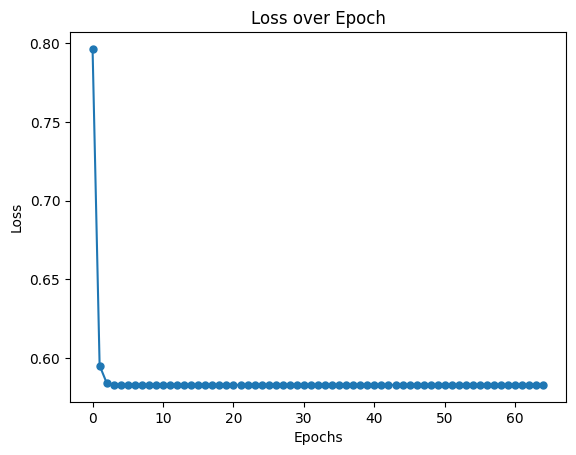

In [42]:
plt.plot(epoch_losses, marker="o", markersize=5)
plt.title("Loss over Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [43]:
# saving the trained model

path = "name_generator_LSTM.pth"
torch.save(model.state_dict(), path)

In [44]:
# Downloading the trained model

from google.colab import files

files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Demo generating new names

In [45]:
# Loading saved model

# path = "classifier.pth"
# model = Model(input_size=num_chars, hidden_size=hidden_size, output_size=num_chars, num_layers=num_layers)
# model = nn.DataParallel(model)
# model.load_state_dict(torch.load(path))

In [46]:
names = sample_names(model, start='je', n=10, k=5, only_new=True)
print(names)

['Jemiamahis', 'Jepidolesto', 'Jelnet', 'Jeifran', 'Jenal', 'Jeryn', 'Jemetyersop', 'Jedrynneshuan', 'Jefriketae', 'Jemasoth', 'Jearo']


In [47]:
generate_name(model)

'jceathiceantot.'

# EOF